In [72]:
item_nm = '무'

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost.callback import EarlyStopping
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# 1. 데이터 로드 및 정렬
df = pd.read_csv(f"EDA/{item_nm}_월차_작년평균단가포함.csv", encoding="cp949")
df = df.drop(columns=["등급코드"], errors="ignore")
df["week_start"] = pd.to_datetime(df["week_start"])
df = df.sort_values("week_start")

group_cols = ["직팜산지코드"]

# 2. 타겟 변경: 변동률 예측
df["평균단가_직전주"] = df.groupby(group_cols)["평균단가(원)"].shift(1)
df["target_ratio"] = (df["평균단가(원)"] - df["평균단가_직전주"]) / df["평균단가_직전주"]

# 3. 파생변수 생성
df["week_sin"] = np.sin(2 * np.pi * df["week"] / 52)
df["week_cos"] = np.cos(2 * np.pi * df["week"] / 52)
df["연속주차"] = (df["year"] - df["year"].min()) * 52 + df["week"]
df["연도경과"] = df["year"] - df["year"].min()

# 거래량
df["총거래량_lag1"] = df.groupby(group_cols)["총거래량(kg)"].shift(1)
df["총거래량_변화율"] = (df["총거래량(kg)"] - df["총거래량_lag1"]) / df["총거래량_lag1"]
df["총거래량_전년"] = df.groupby(group_cols)["총거래량(kg)"].shift(52)
df["총거래량_전년비"] = (df["총거래량(kg)"] - df["총거래량_전년"]) / df["총거래량_전년"]

# 단가 흐름
for t in range(1, 6):
    df[f"평균단가_t-{t}"] = df.groupby(group_cols)["평균단가(원)"].shift(t)

# 단기 평균, 표준편차
for w in [2, 3, 4]:
    df[f"평균단가_직전{w}주평균"] = df[[f"평균단가_t-{i}" for i in range(1, w+1)]].mean(axis=1)
    df[f"평균단가_직전{w}주표준편차"] = df[[f"평균단가_t-{i}" for i in range(1, w+1)]].std(axis=1)

# 변화율 및 가속도
for t in range(2, 5):
    df[f"단가_변화율_t-{t}"] = (df[f"평균단가_t-{t-1}"] - df[f"평균단가_t-{t}"]) / df[f"평균단가_t-{t}"]
df["단가_가속도"] = df["단가_변화율_t-2"] - df["단가_변화율_t-3"]

# 작년 평균단가 기반
df["작년평균단가_전주"] = df.groupby(group_cols)["작년평균단가(원)"].shift(1)
df["작년평균단가_변화율"] = (df["작년평균단가(원)"] - df["작년평균단가_전주"]) / df["작년평균단가_전주"]

In [73]:
# 모델 입력 피처 구성
features = [
    "week_sin", "week_cos", "연속주차", "연도경과",
    "총거래량(kg)", "총거래량_변화율", "총거래량_전년비",
    "작년평균단가(원)", "작년평균단가_변화율",
    "단가_가속도"
] + \
[f"평균단가_t-{i}" for i in range(1, 6)] + \
[f"평균단가_직전{w}주평균" for w in [2, 3, 4]] + \
[f"평균단가_직전{w}주표준편차" for w in [2, 3, 4]]

# 학습 데이터 분리
df_train = df[(df["year"] >= 2019) & (df["year"] <= 2024)]
df_train = df_train.dropna(subset=["target_ratio"] + features).copy()

# 인코딩
le = LabelEncoder()
df_train["직팜산지코드_le"] = le.fit_transform(df_train["직팜산지코드"])

# 입력/출력
X = df_train[features].astype(np.float32)
y = df_train["target_ratio"]

# 시간 기준 분할
split_date = df_train["week_start"].quantile(0.8)
X_train = X[df_train["week_start"] <= split_date]
X_val = X[df_train["week_start"] > split_date]
y_train = y[df_train["week_start"] <= split_date]
y_val = y[df_train["week_start"] > split_date]

# 스케일링
scale_cols = ["총거래량(kg)", "총거래량_변화율", "총거래량_전년비", "작년평균단가_변화율"]
scaler = ColumnTransformer([("scale", RobustScaler(), scale_cols)], remainder="passthrough")
pipe = Pipeline([("scale", scaler)])
X_train_scaled = pipe.fit_transform(X_train)
X_val_scaled = pipe.transform(X_val)


In [74]:
# 모델 학습
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.07,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.3,
    min_child_weight=1,
    objective="reg:pseudohubererror",
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)], callbacks=[EarlyStopping(rounds=20)], verbose=True)

# 검증 성능
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_val, model.predict(X_val_scaled)))
mae = mean_absolute_error(y_val, model.predict(X_val_scaled))
r2 = r2_score(y_val, model.predict(X_val_scaled))
nmae = mae / np.mean(np.abs(y_val))

print("\n✅ 검증 성능:")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"R²   : {r2:.4f}")
print(f"NMAE : {nmae:.4f}")

[0]	validation_0-mphe:0.33712
[1]	validation_0-mphe:0.31596
[2]	validation_0-mphe:0.29307


C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-mphe:0.27611
[4]	validation_0-mphe:0.26112
[5]	validation_0-mphe:0.25013
[6]	validation_0-mphe:0.23957
[7]	validation_0-mphe:0.23035
[8]	validation_0-mphe:0.22193
[9]	validation_0-mphe:0.21496
[10]	validation_0-mphe:0.21119
[11]	validation_0-mphe:0.20632
[12]	validation_0-mphe:0.20319
[13]	validation_0-mphe:0.20037
[14]	validation_0-mphe:0.19629
[15]	validation_0-mphe:0.19438
[16]	validation_0-mphe:0.19248
[17]	validation_0-mphe:0.18853
[18]	validation_0-mphe:0.18702
[19]	validation_0-mphe:0.18478
[20]	validation_0-mphe:0.18220
[21]	validation_0-mphe:0.18008
[22]	validation_0-mphe:0.17773
[23]	validation_0-mphe:0.17555
[24]	validation_0-mphe:0.17435
[25]	validation_0-mphe:0.17278
[26]	validation_0-mphe:0.17151
[27]	validation_0-mphe:0.16990
[28]	validation_0-mphe:0.16875
[29]	validation_0-mphe:0.16756
[30]	validation_0-mphe:0.16687
[31]	validation_0-mphe:0.16570
[32]	validation_0-mphe:0.16483
[33]	validation_0-mphe:0.16390
[34]	validation_0-mphe:0.16269
[35]	validation

In [81]:
# ✅ 2025년 테스트셋 처리 및 예측
start_date = df[(df['year'] == 2024) & (df['week'] == 23)]["week_start"].min()
end_date = df[(df['year'] == 2025) & (df['week'] == 22)]["week_start"].max()
df_test = df[(df["week_start"] >= start_date) & (df["week_start"] <= end_date)].copy()

# 파생변수 재생성 (학습과 동일하게)
df_test["실제값"] = df_test["평균단가(원)"]
for col in features:
    if col not in df_test.columns:
        df_test[col] = np.nan

# 동일 파생 처리
df_test = df_test[df_test["직팜산지코드"].isin(le.classes_)].copy()
df_test["직팜산지코드_le"] = le.transform(df_test["직팜산지코드"])
X_test = df_test[features].astype(np.float32)
X_test = X_test.dropna()
df_test = df_test.loc[X_test.index].copy()
X_test_scaled = pipe.transform(X_test)
y_pred_ratio = model.predict(X_test_scaled)
df_test["예측_변동률"] = y_pred_ratio
df_test["예측값"] = df_test["평균단가_t-1"] * (1 + df_test["예측_변동률"])

# 성능 출력 (실제값 있는 경우만)
if "실제값" in df_test.columns:
    y_true = df_test["실제값"].values
    y_pred = df_test["예측값"].values
    print("\n📊 2025년 테스트셋 성능:")
    print(f"✅ RMSE (test): {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"✅ MAE  (test): {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"✅ R²   (test): {r2_score(y_true, y_pred):.4f}")
    print(f"✅ NMAE (test): {mean_absolute_error(y_true, y_pred) / np.mean(np.abs(y_true)):.4f}")


📊 2025년 테스트셋 성능:
✅ RMSE (test): 315.07
✅ MAE  (test): 235.70
✅ R²   (test): 0.2990
✅ NMAE (test): 0.2799


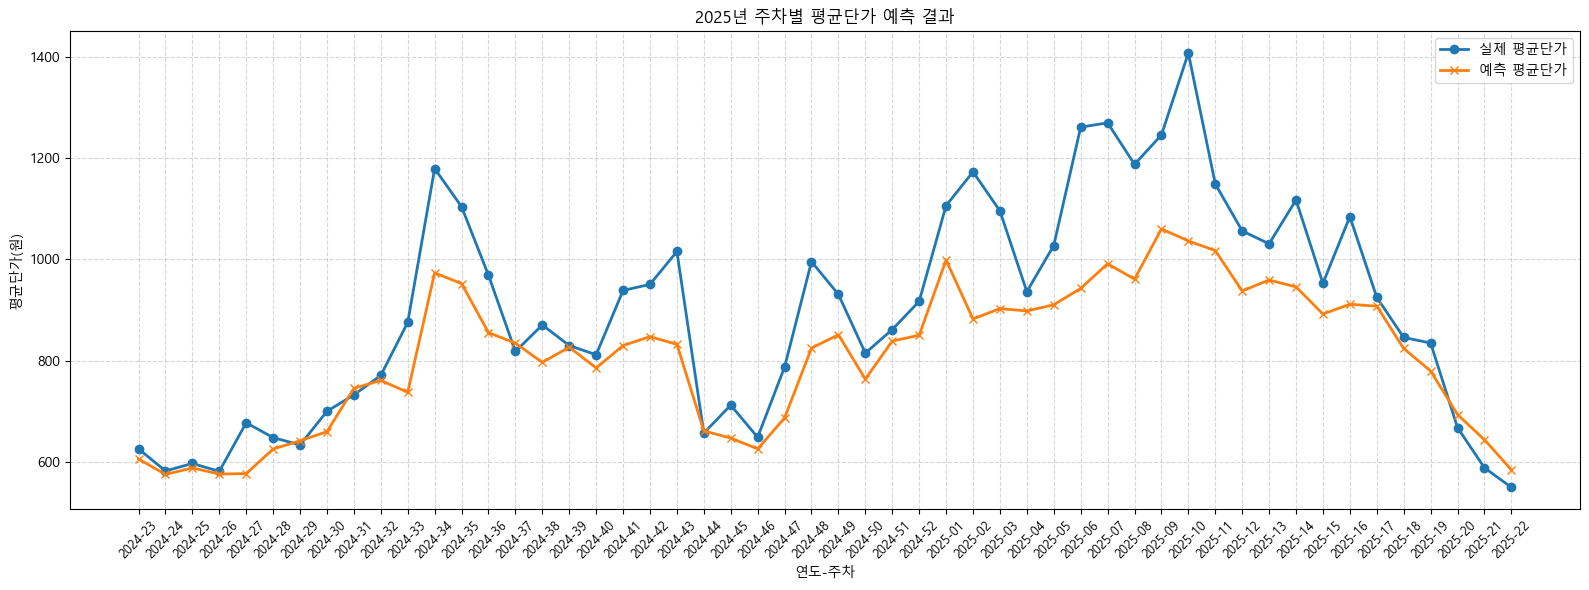

In [82]:
# ✅ 시각화
plot_df = df_test.reset_index(drop=True)
plot_df["year"] = plot_df["year"].astype(int)
plot_df["week"] = plot_df["week"].astype(int)
weekly_avg = (
    plot_df.groupby(["year", "week"])[["실제값", "예측값"]]
    .mean()
    .reset_index()
)
weekly_avg["연도_주차"] = weekly_avg["year"].astype(str) + "-" + weekly_avg["week"].astype(str).str.zfill(2)
plt.figure(figsize=(16, 6))
plt.plot(weekly_avg["연도_주차"], weekly_avg["실제값"], label="실제 평균단가", marker="o", linewidth=2)
plt.plot(weekly_avg["연도_주차"], weekly_avg["예측값"], label="예측 평균단가", marker="x", linewidth=2)
plt.title("2025년 주차별 평균단가 예측 결과")
plt.xlabel("연도-주차")
plt.ylabel("평균단가(원)")
plt.xticks(rotation=45, fontsize=9)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()